In [1]:
from gym import Env
from gym.spaces import Discrete, Box, Dict
import numpy as np
import random

from agent import Agent
import matplotlib.pyplot as plt

# This part allows the graph to be drawn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
class Heater(Env):
    def __init__(self):

        # Action declaration
        self.action_space = Dict({
            "discrete": Discrete(3), # Discrete actions up, down, stay
            "continuous": Box(low=np.array([0.,]), high=np.array([5.,]), dtype=np.float32) 
        })

        # Temperature array
        self.low = np.array([0.])
        self.high = np.array([100.])
        self.observation_space = Box(low=self.low, high=self.high, dtype=np.float32)
        # Set start temp and start time
        self.reset()
        
    def step(self, action):
        temp = self.state

        d_action = action["discrete"]
        c_action = action["continuous"]

        if d_action == 0: # Increase temperature
            temp += c_action
        
        elif d_action == 1: # Decrease temperature
            temp -= c_action
        
        elif d_action == 2:
            temp += 0
        
        self.state = np.array(temp, dtype=np.float32)
            

        # Reduce shower length by 1 second
        self.shower_length -= 1 

        done = bool(
            37. <= self.state <= 39.
            or self.shower_length <= 0
        )

        if done:
            reward = 30
        else:
            reward = -1
        
            
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement visualization --> in this case is not built
        pass
    
    def reset(self):
        # Reset shower temperature
        temp =  random.randint(0, 50)
        self.state = np.array([temp], dtype=np.float32)
        
        # Reset shower time
        self.shower_length = 60 
        return self.state


In [3]:
env = Heater()
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    temps = []

    while not done:
        action = env.action_space.sample()  
        temp, reward, done, info = env.step(action)
        temps.append(temp) 
        score +=reward
    mean_temp = np.mean(np.array(temps))
    print(f'Episode: {episode}, Mean temperature: {mean_temp:.2f} Score: {score}')

Episode: 1, Mean temperature: 15.50 Score: -29
Episode: 2, Mean temperature: 34.31 Score: 12
Episode: 3, Mean temperature: 60.30 Score: -29
Episode: 4, Mean temperature: 17.93 Score: -14
Episode: 5, Mean temperature: 33.56 Score: 22
Episode: 6, Mean temperature: 3.66 Score: -29
Episode: 7, Mean temperature: 12.74 Score: -29
Episode: 8, Mean temperature: 42.91 Score: 22
Episode: 9, Mean temperature: 37.90 Score: 30
Episode: 10, Mean temperature: 50.01 Score: -5


c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
if __name__ == '__main__':
    env = Heater()
    N = 2048
    batch_size = 64
    n_epochs = 10
    alpha = 0.0003
    max_action = env.action_space["continuous"].high[0]

    agent = Agent(actions=env.action_space, input_dims=env.observation_space.shape, 
        fc1_dims=128, fc2_dims=128, gamma=0.99, alpha=alpha,
        gae_lambda=0.95, policy_clip=0.2, batch_size=batch_size, n_epochs=n_epochs)

    score_history = []
    max_steps = 500e3
    total_steps = 0
    traj_length = 0
    episode = 1

    # for i in range(n_games):
    while total_steps < max_steps:
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action_d, probs_d, action_c, probs_c = agent.choose_action(observation)
            action = {
                "discrete": action_d,
                "continuous": action_c 
            }
            observation_, reward, done, info = env.step(action)
            total_steps += 1
            traj_length += 1
            score += reward
            agent.remember(observation, observation_, action_d, action_c, probs_d, probs_c, reward, done)
            if traj_length % N == 0:
                agent.learn()
                traj_length = 0
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        print('{} Episode {} total steps {} avg score {:.1f}'.
              format("Heater", episode, total_steps, avg_score))
        episode += 1

c:\Users\Lenovo\Desktop\Python\Reinforcement Learning\5. PPO\Hybrid PPO\agent.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation], dtype=T.float)


Heater Episode 1 total steps 60 avg score -29.0
Heater Episode 2 total steps 120 avg score -29.0
Heater Episode 3 total steps 180 avg score -29.0
Heater Episode 4 total steps 240 avg score -29.0
Heater Episode 5 total steps 300 avg score -29.0
Heater Episode 6 total steps 360 avg score -29.0
Heater Episode 7 total steps 420 avg score -29.0
Heater Episode 8 total steps 480 avg score -29.0
Heater Episode 9 total steps 540 avg score -29.0
Heater Episode 10 total steps 600 avg score -29.0
Heater Episode 11 total steps 642 avg score -27.4
Heater Episode 12 total steps 702 avg score -27.5
Heater Episode 13 total steps 762 avg score -27.6
Heater Episode 14 total steps 822 avg score -27.7
Heater Episode 15 total steps 882 avg score -27.8
Heater Episode 16 total steps 883 avg score -24.2
Heater Episode 17 total steps 943 avg score -24.5
Heater Episode 18 total steps 981 avg score -23.5
Heater Episode 19 total steps 1038 avg score -23.6
Heater Episode 20 total steps 1098 avg score -23.9
Heater E

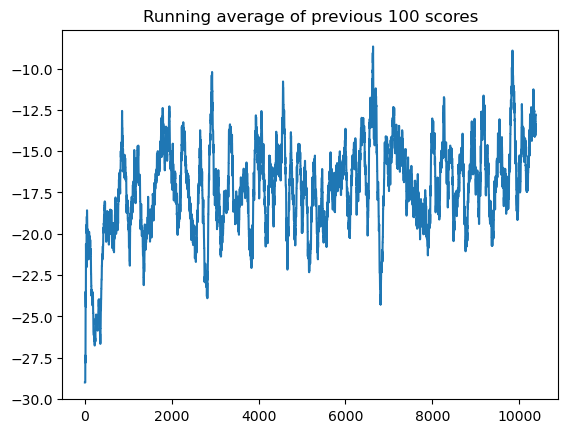

In [5]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')

x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history)